Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
IIC2433 - Minería de Datos
<br>

<center>
    <h2> Tarea 3 </h2>
    <h1>   </h1>
    <p>
        Profesor Marcelo Mendoza<br>
        Segundo Semestre 2022<br>    
        Fecha de entrega: Viernes 14 de octubre 22.00 horas
    </p>
    <br>
</center>

<br>

---

## Indicaciones

Deberás entregar **SOLO** el archivo .ipynb en el buzón respectivo en canvas. 

**IMPORTANTE**: 
- Se te dará puntaje tanto por código como por la manera en la que respondas las preguntas planteadas. Es decir, si tienes un código perfecto pero este no es explicado o no se responden preguntas asociadas a este, no se tendrá el puntaje completo.
- El notebook debe tener todas las celdas de código ejecutadas. Cualquier notebook que no las tenga no podrá ser corregido.
- El carácter de esta tarea es **INDIVIDUAL**. Cualquier instancia de copia resultará en un 1,1 como nota de curso.

# Introducción
Las últimas elecciones parlamentarias resultaron en la configuración de un Congreso fragmentado, en donde ningún pacto alcanza el 35% de los asientos. En total, hay 21 partidos representados repartidos en 8 pactos electorales. En este sentido, es importante encontrar alguna forma de entender el comportamiento de los legisladores mediante sus votos, cosa tal de entender cómo se organizan las fuerzas políticas de facto. Para ello, aplicaremos lo aprendido con Gaussian Mixture Models con las votaciones realizadas hasta el 31 de septiembre de 2022.


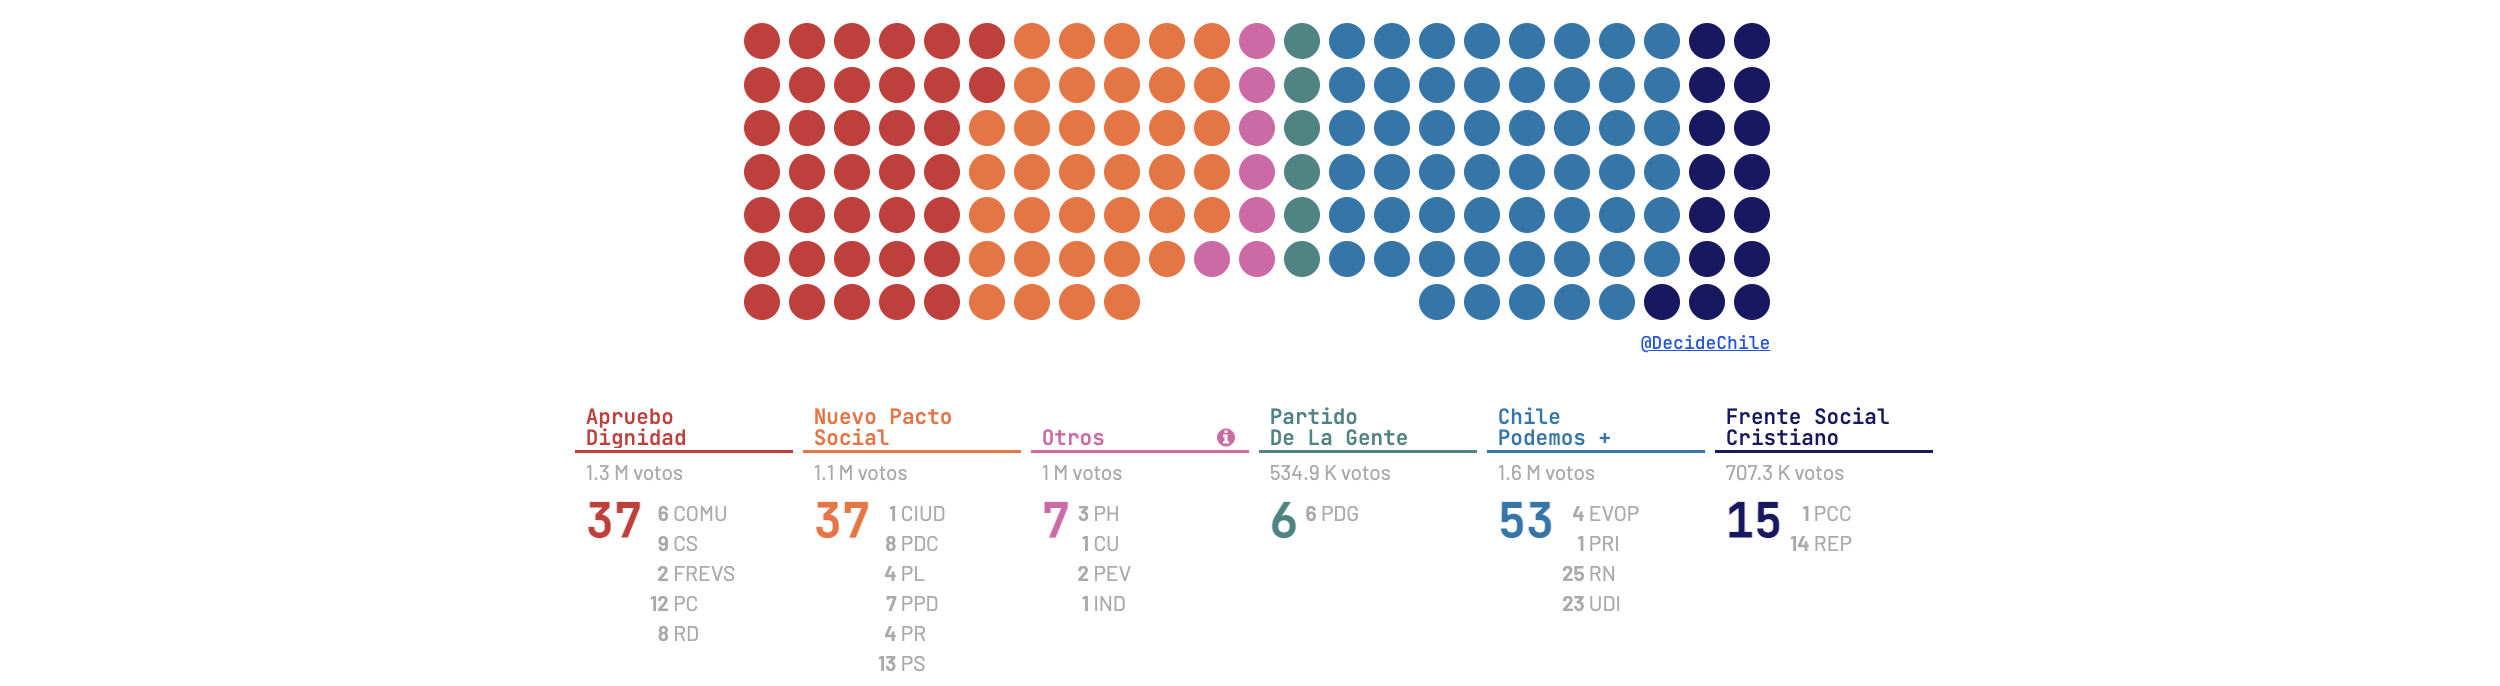
Más info en [este link](https://2021.decidechile.cl/#/ev/2021.nov/ct/2021.nov.D/)

# 0. Setup
En esta tarea trabajarás con 3 bases de datos
- X: voto individual da cada diputado por votación. -1 si votó en contra, 0 por abtensiones y +1 a favor. Si un legislador no vota, se asume como abstención.
- votes: información de una votación. Incluye fecha, descripción y tipo de votación.
- info: información de un legislador. Incluye distrito, pacto y partido.

In [1]:
import pandas as pd
import numpy as np

In [2]:
X = pd.read_csv('https://drive.google.com/uc?id=1aza6H6pI_fc1KXEInesxRSvBrXxCX-O9', index_col=0).fillna(0)
X.columns = [int(c) for c in X.columns]
X.head(2)

,38467,38468,38469,38474,38475,38476,38477,38478,38481,38482,...,39203,39204,39205,39206,39209,39210,39211,39212,39213,39214
"Ahumada Palma, Yovana",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"Fuenzalida Cobo, Juan",1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
votes = pd.read_csv('https://drive.google.com/uc?id=1ujxbWmI2oRqB7Zrh2wL9wkRwK8dhFuVF', index_col=0)
votes.head()

,datetime,description,type
38467,2022-03-16,La Cámara de Diputados manifiesta su más absol...,Proyecto Resolucion
38468,2022-03-16,La Cámara de Diputados manifiesta su más absol...,Proyecto Resolucion
38481,2022-03-22,La Cámara de Diputados solicita a S. E. el Pre...,Proyecto Resolucion
38482,2022-03-22,La Cámara de Diputados manifiesta su más absol...,Proyecto Resolucion
38483,2022-03-22,Solicita a S. E. el Presidente de la República...,Proyecto Resolucion


In [4]:
info = pd.read_excel('https://drive.google.com/uc?id=1UwqK5j-IbD1Ufpx4-5hBfUnvL2EzpfTB', index_col=0)
info.head()

,shortname,district,pact,party
"Romero Leiva, Agustín",Agustin Romero,8,FSC,REP
"Undurraga Vicuña, Alberto",Alberto Undurraga,8,NPS,DC
"Placencia Cabello, Alejandra",Alejandra Placencia,10,AD,PC
"Bernales Maldonado, Alejandro",Alejandro Bernales,26,NPS,PL
"Sepúlveda Soto, Alexis",Alexis Sepulveda,17,NPS,PR


# 1. Preguntas teóricas (1.5 pts)

### 1.1 ¿Que es un modelo Gaussian Mixtures? ¿En qué escenarios funciona bien y en qué mal?

Un modelo Gaussian Mixtures es un modelo probabilístico que supone que todos los puntos de datos se generan a partir de una mezcla de un número finito de distribuciones gaussianas con parámetros desconocidos. Se puede pensar también como una generalización del agrupamiento de k-medias para incorporar información sobre la estructura de covarianza de los datos, así como los centros de las gaussianas latentes.

Este es el algoritmo más rápido para modelos learning mixture. Debido a que el algoritmo maximiza la probabilidad de que un evento ocurra, no sesgará las medias a 0, ni los tamaños de los clusters para tener estructuras que no podrían aplicarse. Cuando no se tienen suficientes puntos por mixture la estimación de la matriz de covarianzas resulta compleja, por lo que el algoritmo funcionará peor y encontrará soluciones con probabilidad infinita a no ser que se regule la covarianza artificialmente. El algoritmo siempre usará todos los componentes a los que tiene acceso.

https://scikit-learn.org/stable/modules/mixture.html

### 1.2 Investiga sobre el hiperparámetro covariance_type. ¿Qué es la matriz de covarianza? ¿Qué son y en qué casos serviría aplicar cada uno de los valores que puede tomar covariance_type (full, spherical, diag, tied)?

El hiperparámetro covariance_type controla el nivel de libertad en en la forma que tome cada cluster. Por esto es escencial adecuar este hiperparámetro para cada problema distinto. La matriz de covarianza de una distribución gaussiana determina las direcciones y longitudes de los ejes en los contornos de los elipsoides ocupados para la clusterización. Los casos en los que se puede aplicar los diferentes covariance_type son:
1. full: Los componentes pueden de manera independiente adoptar cualquier forma elíptica o posición. 
2. spherical: Se está en una situación “diagonal” con contornos circulares (esféricos en dimensiones superiores, de ahí el nombre).
3. diag: Significa que los ejes de contorno están orientados a lo largo de los ejes de coordenadas, pero de lo contrario, las excentricidades pueden variar entre los componentes.
4. tied: Los componentes adoptan la misma forma, pero esta forma puede ser de cualquier manera.

https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
https://stats.stackexchange.com/questions/326671/different-covariance-types-for-gaussian-mixture-models
https://towardsdatascience.com/a-simple-introduction-to-gaussian-mixture-model-gmm-f9fe501eef99

### 1.3 ¿Qué significa que GMM sea un modelo generativo?

El que GMM sea un modelo generativo significa que nos brinda un medio natural oara determinar la cantidad óptima de componentes para un conjunto de datos determinados. Un modelo generativo es inherentemente una distribución de probabilidad para el conjunto de datos, por lo que simplemente podemos evaluar la probabilidad de los datos bajo el modelo, utilizando la validación cruzada para evitar el ajuste excesivo.

https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

### 1.4 ¿Qué es el algoritmo Expectation-Maximization? ¿Qué estima? ¿Cuál es su relación y diferencia con K-Means?

El algoritmo Expectation-Maximization (EM) es una manera de estimar la densidad de un conjunto de datos mediante la busqueda de distribuciones de probabilidad y sus parámetros. La máxima verosimilitud se vuelve intratable si hay variables que interactúan con las del conjunto de datos pero estaban ocultas o no se observaron. Estas son las llamadas variables latentes. EM es un método de aplicar máximum likelihood en presencia de variables latentes. Lo hace primero estimando los valores de estas variables y luego optimizando el modelo, repitiendo estos pasos hasta la convergencia. El EM es un método muy utilizado para estimar densidades con datos faltantes. Se ocupa en algoritmos de clustering tales como Gaussian Mixture Model.

EM y K-means son similares en el sentido de que permiten refinar el modelo de un proceso iterativo para encontrar la mejor congestión. Sin embargo, el algoritmo de K-medias difiere en el método utilizado para calcular la distancia euclidiana al calcular la distancia entre cada uno de los dos elementos de datos. EM utiliza métodos estadísticos. El algoritmo EM se usa a menudo para proporcionar las funciones de manera más efectiva.

https://machinelearningmastery.com/expectation-maximization-em-algorithm/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4433949/#:~:text=EM%20and%20K%2Dmeans%20are,and%20EM%20uses%20statistical%20methods.

### 1.5 Investiga sobre Bayesian Information Criterion y Akaike Information Criterion. ¿Qué son y para qué sirven?
Los indicadores de información miden el balance entre capacidad predictiva y complejidad. Generalmente, cuanto más complejo es un modelo (porque tiene muchas variables, interacciones, etc) mejor describirá el proceso que estamos analizando, pero si es demasiado complejo perderá generalidad (será muy bueno prediciendo los datos para los que está entrenado, pero nada más allá de eso). Asique tenemos un compromiso: queremos un modelo lo suficientemente complejo para que sea una buena descripción de nuestro sistema de estudio, pero no tan complejo como para que no tenga validez general.

Akaike Information Criterion (AIC):

    AIC = 2k - 2ln(L)
    
Donde k es el número de parámetros y L es el máximo de la función de verosimilitud (Maximum likelihood del modelo). Es decir, según AIC, la bondad de ajuste es el valor de Maximum Likelihood y la complejidad es el número de parámetros. Al comparar modelos, elegimos el que tiene menor AIC y establecemos que no son “significativos” los cambios de AIC menores que 2. AIC perdona que el modelo sea muy complejo siempre y cuando posea muchos datos para avalar cada parámetro. Esto se debe a que el AIC tiene como objetivo seleccionar el modelo que mejor hace predicciones dentro de un set de datos. Esto es muy conservador, pero puede que no sea lo que queremos en todo momento.

Bayesian Information Criterion (BIC):
    
    BIC = kln(n)-2ln(L)
   
Donde k es el número de parámetros, L es el Maximum Likelihood y n es el número de datos. Sin embargo ahora la medida de la complejidad incorpora tanto k como ln(n). Por lo tanto, los efectos de aumentar la complejidad ya no son tan minúsculos, porque ahora el número de parámetros k no aparece sólo, sino como un factor que multiplica al tamaño muestral.
Es decir, BIC penaliza más la complejidad que AIC, busca el modelo más abstracto, más sencillo y que hace predicciones en un contexto más amplio. Por su parte AIC dará con un modelo más complejo y pragmático que hace predicciones con mayor detalle dentro de nuestros propios datos.

https://jrubalcaba.github.io/posts/information_criterion/#:~:text=Criterio%20de%20Informaci%C3%B3n%20Bayesiano&text=Es%20decir%2C%20BIC%20penaliza%20m%C3%A1s,dentro%20de%20nuestros%20propios%20datos.

### 1.6 Investiga sobre Bayesian Gaussian Mixture Models. ¿Qué es y para qué sirve?

Los Bayesian Gaussian Mixture Models constituyen una forma de aprendizaje no supervisado y pueden ser útiles para ajustar datos multimodales para tareas como agrupación, compresión de datos, detección de valores atípicos o clasificadores generativos. Cada componente gaussiano suele ser una multivariable gaussiana con un mean vector y una matriz de covarianza. Es una variante del Gaussian Mixture Model y de Variational Inference Algorithm. Con GMM podemos solo inferir el número de clústers comparando la información con los criterios de AIC y BIC, en cambio Bayesian Gaussian Mixture Models da pesos iguales (o cercanos) a cero a un grupo innecesario. Con este modelo dolo es necesario establecer el parámetro n_components en un valor que tenga buenas razones para creer que es mayor que la cantidad óptima de clústeres y el algoritmo eliminará automáticamente el clúster innecesario.

https://towardsdatascience.com/bayesian-gaussian-mixture-models-without-the-math-using-infer-net-7767bb7494a0#:~:text=Bayesian%20Gaussian%20mixture%20models%20constitutes,outlier%20detection%2C%20or%20generative%20classifiers.
https://scikit-learn.org/stable/modules/mixture.html
https://michael-fuchs-python.netlify.app/2020/06/26/bayesian-gaussian-mixture-models/

# 2. Gaussian Mixtures Model (2.5 ptos)
### 2.1 Visualización inicial
Aplica PCA a las votaciones del Congreso y colorea a cada diputado según el pacto con el que fue electo


In [5]:
from sklearn.decomposition import PCA

Haremos un PCA de 2 dimensiones para poder graficar

In [6]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

pca_n2 = pd.DataFrame(data = principalComponents
             , columns = ['component 1', 'component 2'])
pca_n2.index = X.index
pca_n2.head()

,component 1,component 2
"Ahumada Palma, Yovana",5.525829,-5.826019
"Fuenzalida Cobo, Juan",9.259212,1.213378
"Ossandón Irarrázabal, Ximena",5.212597,-4.636242
"Alessandri Vergara, Jorge",9.368172,3.475531
"González Villarroel, Mauro",8.087652,-4.208007


Agregamos el partido a cada político:

In [7]:
pact_list = []
party_list = []
name_list = []
for i in range(len(pca_n2)):
    for j in range(len(info)):
        if pca_n2.index[i] == info.index[j]:
            pact_list.append(info.pact[j])
            party_list.append(info.party[j])
            name_list.append(info.shortname[j])

In [8]:
pca_n2['pact'] = pact_list
pca_n2['party'] = party_list
pca_n2['s_name'] = name_list
pca_n2.head()

,component 1,component 2,pact,party,s_name
"Ahumada Palma, Yovana",5.525829,-5.826019,PDG,PDG,Yovana Ahumada
"Fuenzalida Cobo, Juan",9.259212,1.213378,CP+,UDI,Juan Fuenzalida
"Ossandón Irarrázabal, Ximena",5.212597,-4.636242,CP+,RN,Ximena Ossandon
"Alessandri Vergara, Jorge",9.368172,3.475531,CP+,UDI,Jorge Alessandri
"González Villarroel, Mauro",8.087652,-4.208007,CP+,RN,Mauro Gonzalez


Text(0.5, 1.0, 'Votaciones de políticos agrupados en pactos')

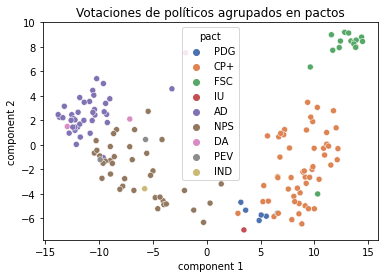

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data = pca_n2,
                x = 'component 1',
                y = 'component 2',
                hue=pca_n2['pact'],
                palette="deep").set_title('Votaciones de políticos agrupados en pactos')

Text(0.5, 1.0, 'Votaciones de políticos agrupados en partidos')

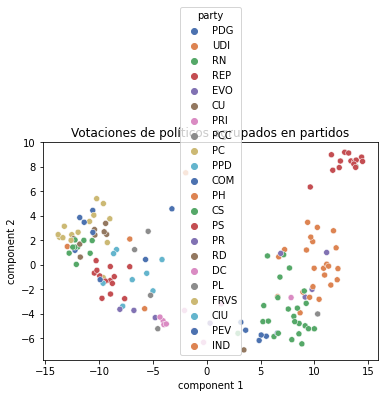

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data = pca_n2,
                x = 'component 1',
                y = 'component 2',
                hue=pca_n2['party'],
                palette="deep").set_title('Votaciones de políticos agrupados en partidos')

### 2.2 Análisis del gráfico
Al visualizar el gráfico, identifica qué pactos se clusterizarían juntos al agrupar a los legisladores en dos bandos. Además, especula qué en cuántos clusters se podrían agrupar los legisladores considerando más de dos bandos.

Se puede ver que hay siertos pactos los cuales están relativamente cerca. Por un lado tenemos a AD y DA en el sector izquierdo del gráfico. Además hay otro grupo más a la centro izquierda con NPS, PEV y IND. Luego a a derecha tenemos que IU, PDG y CP+ tienen posiciones similares. Por último esta FSC bien arriba a la derecha y que no se condice con otros grupos a excepción de un cado aislado. Considerando esta información se puede decir que ha simple vista hay 4 clusters.

### 2.3 Función `clusterize`
Codifica una función que utiliza el modelo `GaussianMixture` de sklearn para separar a los legisladores en `n` grupos según sus votaciones. Debe retornar un dataframe que contenga la clasificación junto con el pacto y partido de cada uno de los legisladores. Corre el método con `n=2`.

In [11]:
from sklearn.mixture import GaussianMixture

https://towardsdatascience.com/gaussian-mixture-models-for-clustering-3f62d0da675

Clusterizamos

In [12]:
def clusterize(x, pca, n, r):
    gm = GaussianMixture(n_components=n, random_state=r)
    label = gm.fit_predict(x)
    pca['label'] = label
    return pca

Ocupamos la funcion

In [13]:
df = clusterize(x=X, pca=pca_n2, n=2, r=18639550)

### 2.4 Visualización con `GMM(n=2)`

Agregamos los componentes del pca para poder graficar.

Text(0.5, 1.0, 'Votaciones de políticos agrupados por GMM n=2')

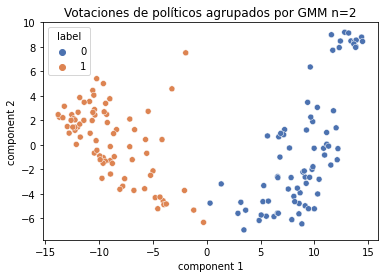

In [14]:
sns.scatterplot(data = df,
                x = 'component 1',
                y = 'component 2',
                hue=df['label'],
                palette="deep").set_title('Votaciones de políticos agrupados por GMM n=2')

In [15]:
df_0 = df.loc[df['label'] == 0]
print(df_0['party'].unique())
print(df_0['pact'].unique())

['PDG' 'UDI' 'RN' 'REP' 'EVO' 'CU' 'PRI' 'PCC' 'DC' 'PR']
['PDG' 'CP+' 'FSC' 'IU' 'NPS']


### 2.5 Preguntas con `GMM(n=2)`
#### 1. ¿Junto a qué partidos o pactos se agrupan los diputados del Partido de la Gente?
Podemos ver que están en el cluster 0 (azul). Los pactos con los que comparten cluster son CP+, FSC, IU y algunos del NPS. Los partidos que se agrupan en este cluster son mayoritariamente de derecha. UDI, RN, REP, EVO, CU, PRI, PCC, DC y PR

#### 2. Dadas las clasificaciones, identifica si existen diputados que se clasifiquen en el cluster contrario al de la mayoría de su partido.

In [16]:
df_0.loc[df_0['pact'] == 'NPS']

,component 1,component 2,pact,party,s_name,label
"Calisto Águila, Miguel Ángel",1.335072,-3.189099,NPS,DC,Miguel Angel Calisto,0
"Jouannet Valderrama, Andrés",0.298402,-4.758732,NPS,PR,Andres Jouannet,0


Podemos ver con los gráficos y los filtros que hay dos puntos pertenecientes al pacto NPS y que a la vez pertenecen al cluster 0. Al tener el pacto fue sencillo identificarlos mediante un filtro. Los diputados son Miguel Angel Calisto de la DC y Andres Jouannet de el PR. El hecho de que pertenezcan al cluster 0 nos indica que no votan como a mayoría de sus partidos ni de su pacto.

### 2.6 Evolución a lo largo del tiempo
Corre la función clusterize dividiendo a las votaciones según el mes en que se realizaron (hay 7 meses en total). Registra las clasificaciones de cada uno de los meses en un solo dataframe.

Primero extraemos los meses y los agregamos a una columna de votes

In [17]:
months = pd.DatetimeIndex(votes['datetime']).month.unique()
votes['month'] = pd.DatetimeIndex(votes['datetime']).month

Ahora creamos un diccionario con el mes y los codigos de la votación pertenecientes a mes

In [18]:
d_months = {}

for month in months:
    d_months[month] = votes.loc[votes['month']==month].index.values

Renombramos la columna de clusters con todos los meses

In [19]:
pca_n2 = pca_n2.rename({'label':'label_complete'})

Procedemos a clusterizar según mes

In [20]:
df_m = pca_n2
for month in months:
    vote_m = X[d_months[month]]
    df_m[f'month_{month}'] = clusterize(x=vote_m, pca=pca_n2, n=2, r=18639550).label

In [21]:
df_m

,component 1,component 2,pact,party,s_name,label,month_3,month_4,month_5,month_6,month_7,month_8,month_9
"Ahumada Palma, Yovana",5.525829,-5.826019,PDG,PDG,Yovana Ahumada,0,0,0,0,0,0,0,0
"Fuenzalida Cobo, Juan",9.259212,1.213378,CP+,UDI,Juan Fuenzalida,0,0,0,0,0,0,0,0
"Ossandón Irarrázabal, Ximena",5.212597,-4.636242,CP+,RN,Ximena Ossandon,0,0,0,0,0,0,1,0
"Alessandri Vergara, Jorge",9.368172,3.475531,CP+,UDI,Jorge Alessandri,0,0,0,0,0,0,0,0
"González Villarroel, Mauro",8.087652,-4.208007,CP+,RN,Mauro Gonzalez,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Mix Jiménez, Claudia",-10.594771,2.652066,AD,COM,Claudia Mix,1,0,1,1,1,1,1,1
"Ilabaca Cerda, Marcos",-7.641657,-2.762885,NPS,PS,Marcos Ilabaca,1,0,1,1,1,1,1,1
"Undurraga Gazitúa, Francisco",6.868621,0.940623,CP+,EVO,Francisco Undurraga,0,0,0,0,0,0,0,0
"Hertz Cádiz, Carmen",-9.019039,3.766837,AD,PC,Carmen Hertz,1,0,1,1,1,1,1,1


### 2.7 Visualización pre/post plebiscito
Analiza lo que ocurrió un mes antes y un mes después del plebiscito. Para eso, primero obtén solamente las votaciones de agosto, aplica el método `clusterize` y luego grafica las clasificaciones usando como base un PCA aplicado solamente a estas votaciones. Realiza lo mismo después para las votaciones de septiembre.

Utilizamos nuestro diccionario con meses para obtener las votaciones de agosto. Clusterizamos y hacemos un PCA

In [22]:
principalComponents = pca.fit_transform(X[d_months[8]])

pca_agosto = pd.DataFrame(data = principalComponents
             , columns = ['component 1', 'component 2'])
pca_agosto.index = X[d_months[8]].index

df_agosto = clusterize(x=X[d_months[8]], pca=pca_agosto, n=2, r=18639550)
df_agosto

,component 1,component 2,label
"Ahumada Palma, Yovana",1.574075,-3.597371,0
"Fuenzalida Cobo, Juan",3.231433,-1.659914,0
"Ossandón Irarrázabal, Ximena",0.407117,-1.058111,1
"Alessandri Vergara, Jorge",2.780361,1.329248,0
"González Villarroel, Mauro",1.351710,-2.595820,1
...,...,...,...
"Mix Jiménez, Claudia",-4.339865,1.193922,1
"Ilabaca Cerda, Marcos",-3.575767,-0.218876,1
"Undurraga Gazitúa, Francisco",1.909908,0.561802,0
"Hertz Cádiz, Carmen",-2.608631,2.602673,1


Graficamos: 

Text(0.5, 1.0, 'Votaciones de políticos agrupados por GMM n=2 en mes de agosto')

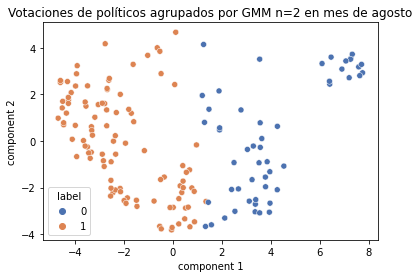

In [23]:
sns.scatterplot(data = df_agosto,
                x = 'component 1',
                y = 'component 2',
                hue=df_agosto['label'],
                palette="deep").set_title('Votaciones de políticos agrupados por GMM n=2 en mes de agosto')

Ahora Septiembre

In [24]:
principalComponents = pca.fit_transform(X[d_months[9]])

pca_septiembre = pd.DataFrame(data = principalComponents
             , columns = ['component 1', 'component 2'])
pca_septiembre.index = X[d_months[9]].index

df_septiembre = clusterize(x=X[d_months[9]], pca=pca_septiembre, n=2, r=18639550)
df_septiembre

,component 1,component 2,label
"Ahumada Palma, Yovana",0.417286,-2.448840,0
"Fuenzalida Cobo, Juan",1.543162,0.292976,0
"Ossandón Irarrázabal, Ximena",0.089727,-2.683412,0
"Alessandri Vergara, Jorge",2.131014,1.274161,0
"González Villarroel, Mauro",0.618075,-3.111788,0
...,...,...,...
"Mix Jiménez, Claudia",-0.125189,3.101914,1
"Ilabaca Cerda, Marcos",-2.526924,-0.114469,1
"Undurraga Gazitúa, Francisco",2.258007,1.771386,0
"Hertz Cádiz, Carmen",-2.640437,1.941025,1


Text(0.5, 1.0, 'Votaciones de políticos agrupados por GMM n=2 en mes de septiembre')

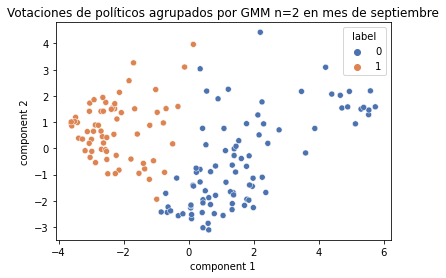

In [25]:
sns.scatterplot(data = df_septiembre,
                x = 'component 1',
                y = 'component 2',
                hue=df_septiembre['label'],
                palette="deep").set_title('Votaciones de políticos agrupados por GMM n=2 en mes de septiembre')

### 2.8 Preguntas con `GMM(n=2)` mensual

#### 1. Analiza las distribuciones del poder. ¿Hay meses en que el sector asociado al oficialismo haya perdido la mayoría absoluta? ¿Si hubo, cuáles fueron?


Agruparemos los labels de los distintos meses para ver en cuales hay mayorías del cluster 0 (oposición) y en cuales del cluster 1 (oficialismo)

In [26]:
for month in months:
    print(f'month_{month}:')
    print(df_m[f'month_{month}'].value_counts())
    print('\n')


month_3:
0    79
1    76
Name: month_3, dtype: int64


month_4:
0    79
1    76
Name: month_4, dtype: int64


month_5:
0    78
1    77
Name: month_5, dtype: int64


month_6:
1    78
0    77
Name: month_6, dtype: int64


month_7:
0    81
1    74
Name: month_7, dtype: int64


month_8:
1    103
0     52
Name: month_8, dtype: int64


month_9:
0    89
1    66
Name: month_9, dtype: int64




Podemos ver que el cluster 1 solo es mayor en cantidad los meses de agosto y junio. Los otros 5 meses tiene mayoría el cluster 0, por lo que se puede decir que el oficialismo a tenido mayoría 2 de 7 meses en el congreso.

#### 2. Identifica a los diputados que en algún momento hayan migrado de un bando a otro. ¿A qué partido y pacto pertenecen en su mayoría?

Sumaremos las filas de los meses en los que ha votado cada diputado. Valores distintos a 0 o a 7 serán los diputados que se han cambiado de bando.

In [27]:
df_m['suma_clusters'] = df_m['month_3'] + df_m['month_4'] + df_m['month_5'] + df_m['month_6'] + df_m['month_7'] + df_m['month_8'] + df_m['month_9']

df_cambiados = df_m.loc[~df_m['suma_clusters'].isin([0,7])]
df_cambiados

,component 1,component 2,pact,party,s_name,label,month_3,month_4,month_5,month_6,month_7,month_8,month_9,suma_clusters
"Ossandón Irarrázabal, Ximena",5.212597,-4.636242,CP+,RN,Ximena Ossandon,0,0,0,0,0,0,1,0,1
"González Villarroel, Mauro",8.087652,-4.208007,CP+,RN,Mauro Gonzalez,0,0,0,0,0,0,1,0,1
"Oyarzo Figueroa, Rubén Darío",4.860956,-6.174260,PDG,PDG,Ruben Oyarzo,0,0,0,0,0,0,1,0,1
"Arroyo Muñoz, Roberto",3.606895,-5.334497,PDG,PDG,Roberto Arroyo,0,0,0,1,0,0,1,0,2
"Pulgar Castillo, Francisco",3.446119,-6.947383,IU,CU,Francisco Pulgar,0,0,0,0,0,0,1,0,1
"Becker Alvear, Miguel Ángel",9.993880,-5.223021,CP+,RN,Miguel Angel Becker,0,0,0,0,0,0,1,0,1
"Beltrán Silva, Juan Carlos",8.832779,-6.453538,CP+,RN,Juan Carlos Beltran,0,0,0,0,0,0,1,0,1
"Raphael Mora, Marcia",8.578208,-4.788861,CP+,RN,Marcia Raphael,0,0,0,0,0,0,1,0,1
"Labra Besserer, Paula",9.233071,-3.143635,CP+,RN,Paula Labra,0,0,0,0,0,0,1,0,1
"Rathgeb Schifferli, Jorge",9.138789,-4.977595,CP+,RN,Jorge Rathgeb,0,0,0,0,0,0,1,0,1


Contamos por pacto y partido

In [28]:
df_cambiados['pact'].value_counts()

CP+    20
NPS    14
AD      4
PDG     3
DA      2
IU      1
Name: pact, dtype: int64

In [29]:
df_cambiados['party'].value_counts()

RN     20
PPD     4
DC      4
PDG     3
PC      2
PH      2
PR      2
PL      2
COM     2
CU      1
CIU     1
PS      1
Name: party, dtype: int64

Podemos ver que los pactos con más diputados cambiantes son CP+ y NPS con 20 y 14 respectivamente. Por otro lado los partidos más cambiantes son RN con 20, PPD con 4 y DC con 3. Se puede destacar que del pacto CP+ el unico partido cambiante es RN.

#### 3. Al analizar los gráficos y las clasificaciones entregadas por GMM, ¿cómo cambió el Congreso entre agosto y septiembre?

Podemos ver que después del plebisito aumentaron los integrantes del cluster 0 significativamente. Los votos ahora son más de derecha en otras palabras. También podemos ver que se redujo la distancia entre votos y los extremos, lo que indica votos menos polarizados tanto en la derecha como la izquierda.

# 3. Bayesian Gaussian Mixtures (2 ptos)

### 3.1 Determinación de cantidad de clusters
Determina una cantidad razonable de clusters utilizando Bayesian Gaussian Mixtures. Justifica tu decisión. (Hint: corre el modelo considerando un `n` más grande del que crees que hay y considera como irrelevante clusters con pesos menores o cercanos a 5-7%). 

Se utiliza https://michael-fuchs-python.netlify.app/2020/06/26/bayesian-gaussian-mixture-models/

In [30]:
from sklearn.mixture import BayesianGaussianMixture

Partimos con 10 como n, ya que es un número elevado de clusters

In [31]:
bay_gmm = BayesianGaussianMixture(n_components=10, n_init=10)
bay_gmm.fit(X)

BayesianGaussianMixture(n_components=10, n_init=10)

Vemos los pesos

In [32]:
bay_gmm_weights = bay_gmm.weights_
np.round(bay_gmm_weights, 2)

array([0.04, 0.24, 0.06, 0.01, 0.25, 0.09, 0.08, 0.05, 0.08, 0.09])

Sacamos los menores a 0.06

In [33]:
n_clusters_ = (np.round(bay_gmm_weights, 2) > 0.06).sum()
print('Numero de clusters estimados: ' + str(n_clusters_))

Numero de clusters estimados: 6


Se estima que un numero razonabe de clusters es 5

### 3.2 Visualiación de `n` óptimo
Dado el `n` que elegiste, obtén los clusters usando `GaussianMixtures` y grafícalos usando la reducción de dimensionalidad.

Clusterizamos con la función antes creada

In [34]:
df_n5 = clusterize(x=X, pca=pca_n2, n=5, r=18639550)

Graficamos

Text(0.5, 1.0, 'Votaciones de políticos agrupados por GMM n=2')

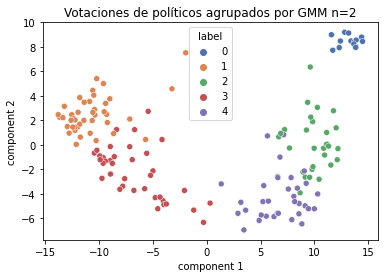

In [35]:
sns.scatterplot(data = df_n5,
                x = 'component 1',
                y = 'component 2',
                hue=df_n5['label'],
                palette="deep").set_title('Votaciones de políticos agrupados por GMM n=2')

### 3.3 Análisis de los clusters
Para cada uno de los clusters, identifica los partidos mayoritarios de cada uno. Realiza dos conclusiones políticas a partir de los resultados.

In [36]:
for i in [0, 1, 2, 3, 4]:  
    print(f'cluster {i}:')
    df = df_n5.loc[df_n5['label'] == i]
    print('Partido:')
    print(df['party'].value_counts())
    print('Pacto:')
    print(df['pact'].value_counts())
    print('\n')

cluster 0:
Partido:
REP    13
RN      1
Name: party, dtype: int64
Pacto:
FSC    13
CP+     1
Name: pact, dtype: int64


cluster 1:
Partido:
PC      12
CS       9
RD       8
COM      6
PH       3
PPD      1
FRVS     1
PS       1
PEV      1
Name: party, dtype: int64
Pacto:
AD     36
DA      3
NPS     2
PEV     1
Name: pact, dtype: int64


cluster 2:
Partido:
UDI    23
EVO     4
REP     1
RN      1
Name: party, dtype: int64
Pacto:
CP+    28
FSC     1
Name: pact, dtype: int64


cluster 3:
Partido:
PS      12
DC       7
PPD      6
PR       4
PL       4
FRVS     1
CIU      1
PEV      1
IND      1
Name: party, dtype: int64
Pacto:
NPS    34
AD      1
PEV     1
IND     1
Name: pact, dtype: int64


cluster 4:
Partido:
RN     23
PDG     6
CU      1
PRI     1
PCC     1
DC      1
Name: party, dtype: int64
Pacto:
CP+    24
PDG     6
IU      1
FSC     1
NPS     1
Name: pact, dtype: int64




Podemos ver que los partidos mayoritarios en cada cluster son:
0. Republicanos
1. PC, CS, RD y COM
2. PS, DC y PPD
3. UDI y EVO
4. RN y PDG

Se pueden hacer 2 conclusiones interesantes. La primera es que los partidos suelen votar en pactos, pero hay una excepción con RN, que vota más parecido al pacto del PDG. Hay excepciones de diputados a esta regla eso si. La segunda conclusión es que la izquierda posee más variedad de partidos y de pactos, pero las tendencias en los votos se agrupan muy bien. El cluster 1 representa a la izquierda y el 2 a la centro izquierda a pesar de los diferentes pactos y partidos.

### 3.4 Detección de Anomalías `GMM(n=2)`
Para un modelo GMM de dos clusters, identifica los diputados pertenecientes al 2% con menor log-likelihood, lo que indica que son más propensos a ser outliers.

Se ocupo https://www.cienciadedatos.net/documentos/py23-deteccion-anomalias-gmm-python.html

Sacamos la log-likelihood de cada diputado

In [37]:
gm_n2 = GaussianMixture(n_components=2, random_state=18639550)
label = gm_n2.fit_predict(X)
log_likelihood = gm_n2.score_samples(X=X)
df_m['log_like_n2'] = log_likelihood
log_likelihood

array([2691.56164752, 2691.56163454, 2691.56163512, 2691.56163003,
       2691.56165967, 2691.56163065, 2691.56165873, 2691.56163916,
       2691.5616344 , 2691.56163902, 2691.56168107, 2691.56166927,
       2691.56167357, 2691.56164682, 2691.56162623, 2691.561676  ,
       2691.56166422, 2691.56162578, 2691.56168085, 2691.56165481,
       2691.56163557, 2691.56162904, 2691.56165287, 2691.56167063,
       2691.56166047, 2691.56162723, 2691.56165235, 2691.56164141,
       2691.56164283, 2691.56162686, 2691.561654  , 2691.56162231,
       2691.56171134, 2691.56164556, 2691.5616526 , 2691.56167651,
       2691.56162459, 2691.561655  , 2691.56162355, 2691.56162863,
       2691.5616363 , 2691.56170197, 2691.56163146, 2691.56162041,
       2691.56166129, 2691.56163854, 2691.56163723, 2691.56163   ,
       2691.56168507, 2691.56165687, 2691.56167647, 2691.5616585 ,
       2691.56177204, 2691.56163151, 2691.56164358, 2691.56165562,
       2691.56162892, 2691.5616353 , 2691.56164897, 2691.56163

In [38]:
df_m.loc[df_m['log_like_n2'] <= df_m['log_like_n2'].quantile(0.02)]

,component 1,component 2,pact,party,s_name,label,month_3,month_4,month_5,month_6,month_7,month_8,month_9,suma_clusters,log_like_n2
"Jiles Moreno, Pamela",-7.163816,2.110096,DA,PH,Pamela Jiles,1,1,1,1,1,0,1,1,6,2690.047879
"Mirosevic Verdugo, Vlado",-5.455404,2.739382,NPS,PL,Vlado Mirosevic,3,1,1,1,1,1,1,0,6,2690.047884
"González Gatica, Félix",-5.698537,0.437585,PEV,PEV,Felix Gonzalez,1,1,1,1,1,1,1,1,7,2690.047882
"Alinco Bustos, René",-4.167841,0.433686,NPS,PPD,Rene Alinco,3,1,1,1,0,1,1,0,5,2690.047871


Los más propensos a ser outliers son Pamela Jiles, Vlado Mirosevic, Felix Gonzalez y Rene Alinco para GMM n=2

### 3.5 Detección de Anomalías `GMM(n)`
Realiza lo mismo pero siendo `n` la cantidad de clusters que identificaste con `BayesianGaussianMixtures`.

In [39]:
gm_n5 = GaussianMixture(n_components=5, random_state=18639550)
label = gm_n5.fit_predict(X)
log_likelihood = gm_n5.score_samples(X=X)
df_m['log_like_n5'] = log_likelihood

In [40]:
df_m.loc[df_m['log_like_n5'] <= df_m['log_like_n5'].quantile(0.02)]

,component 1,component 2,pact,party,s_name,label,month_3,month_4,month_5,month_6,month_7,month_8,month_9,suma_clusters,log_like_n2,log_like_n5
"Jiles Moreno, Pamela",-7.163816,2.110096,DA,PH,Pamela Jiles,1,1,1,1,1,0,1,1,6,2690.047879,2938.413939
"Molina Milman, Helia",-8.667560,0.921706,NPS,PPD,Helia Molina,1,1,1,1,1,1,1,1,7,2690.047885,2938.413940
"Nuyado Ancapichún, Emilia",-10.295555,0.346196,NPS,PS,Emilia Nuyado,1,1,1,1,1,1,1,1,7,2690.047886,2938.413940
"González Gatica, Félix",-5.698537,0.437585,PEV,PEV,Felix Gonzalez,1,1,1,1,1,1,1,1,7,2690.047882,2938.413939


Los más propensos a ser outliers son Pamela Jiles, Helina Molina, Felix Gonzalez y Emilia Nuyado para GMM n=5. Se repiten 2 diputados